# Data fitting in Julia
## Fitting data to a user-defined function. 
Imports:

In [24]:
using LsqFit
using Distributions
using Plots
using Smoothing
using LaTeXStrings
using Measures
using LinearAlgebra

Now define some nice plot defaults:

In [2]:
default(fontfamily = "Computer Modern", size=(1200,800), titlefont = (16), legendfontsize = 10, 
        guidefont = (16, :darkgreen), tickfont = (12, :black), 
        framestyle = :box, yminorgrid = true, xminorgrid= true,legend = :topright, dpi=300, margin = 7mm)

Our model will be a commonly occuring situation in physics:
a damped oscillator (common examples are a mass on a spring with
linear damping, the charge in an RLC circuit):

$$ m(t,p) = p_1 e^{-t/p_2} \cos(p_3 t + p_4) $$

In [3]:
model(t, p) = p[1] * exp.(-t./p[2]) .* cos.(p[3]*t .+ p[4]) 

model (generic function with 1 method)

In [4]:
tmin, tmax, N_times = 0.0, 10.0, 200
Δy = 0.20
dt = (tmax-tmin)/N_times
tdata = collect(LinRange(tmin,tmax,N_times))
δt = 0.1*dt*ones(length(tdata))
δy  = rand(Normal(0, Δy),length(tdata))
ydata = model(tdata, [2.0, 3.0, 2π, 0.0]) + δy
#initial guess for fit:
p0 = [1.0, 1.0, 2.0, 1.0];

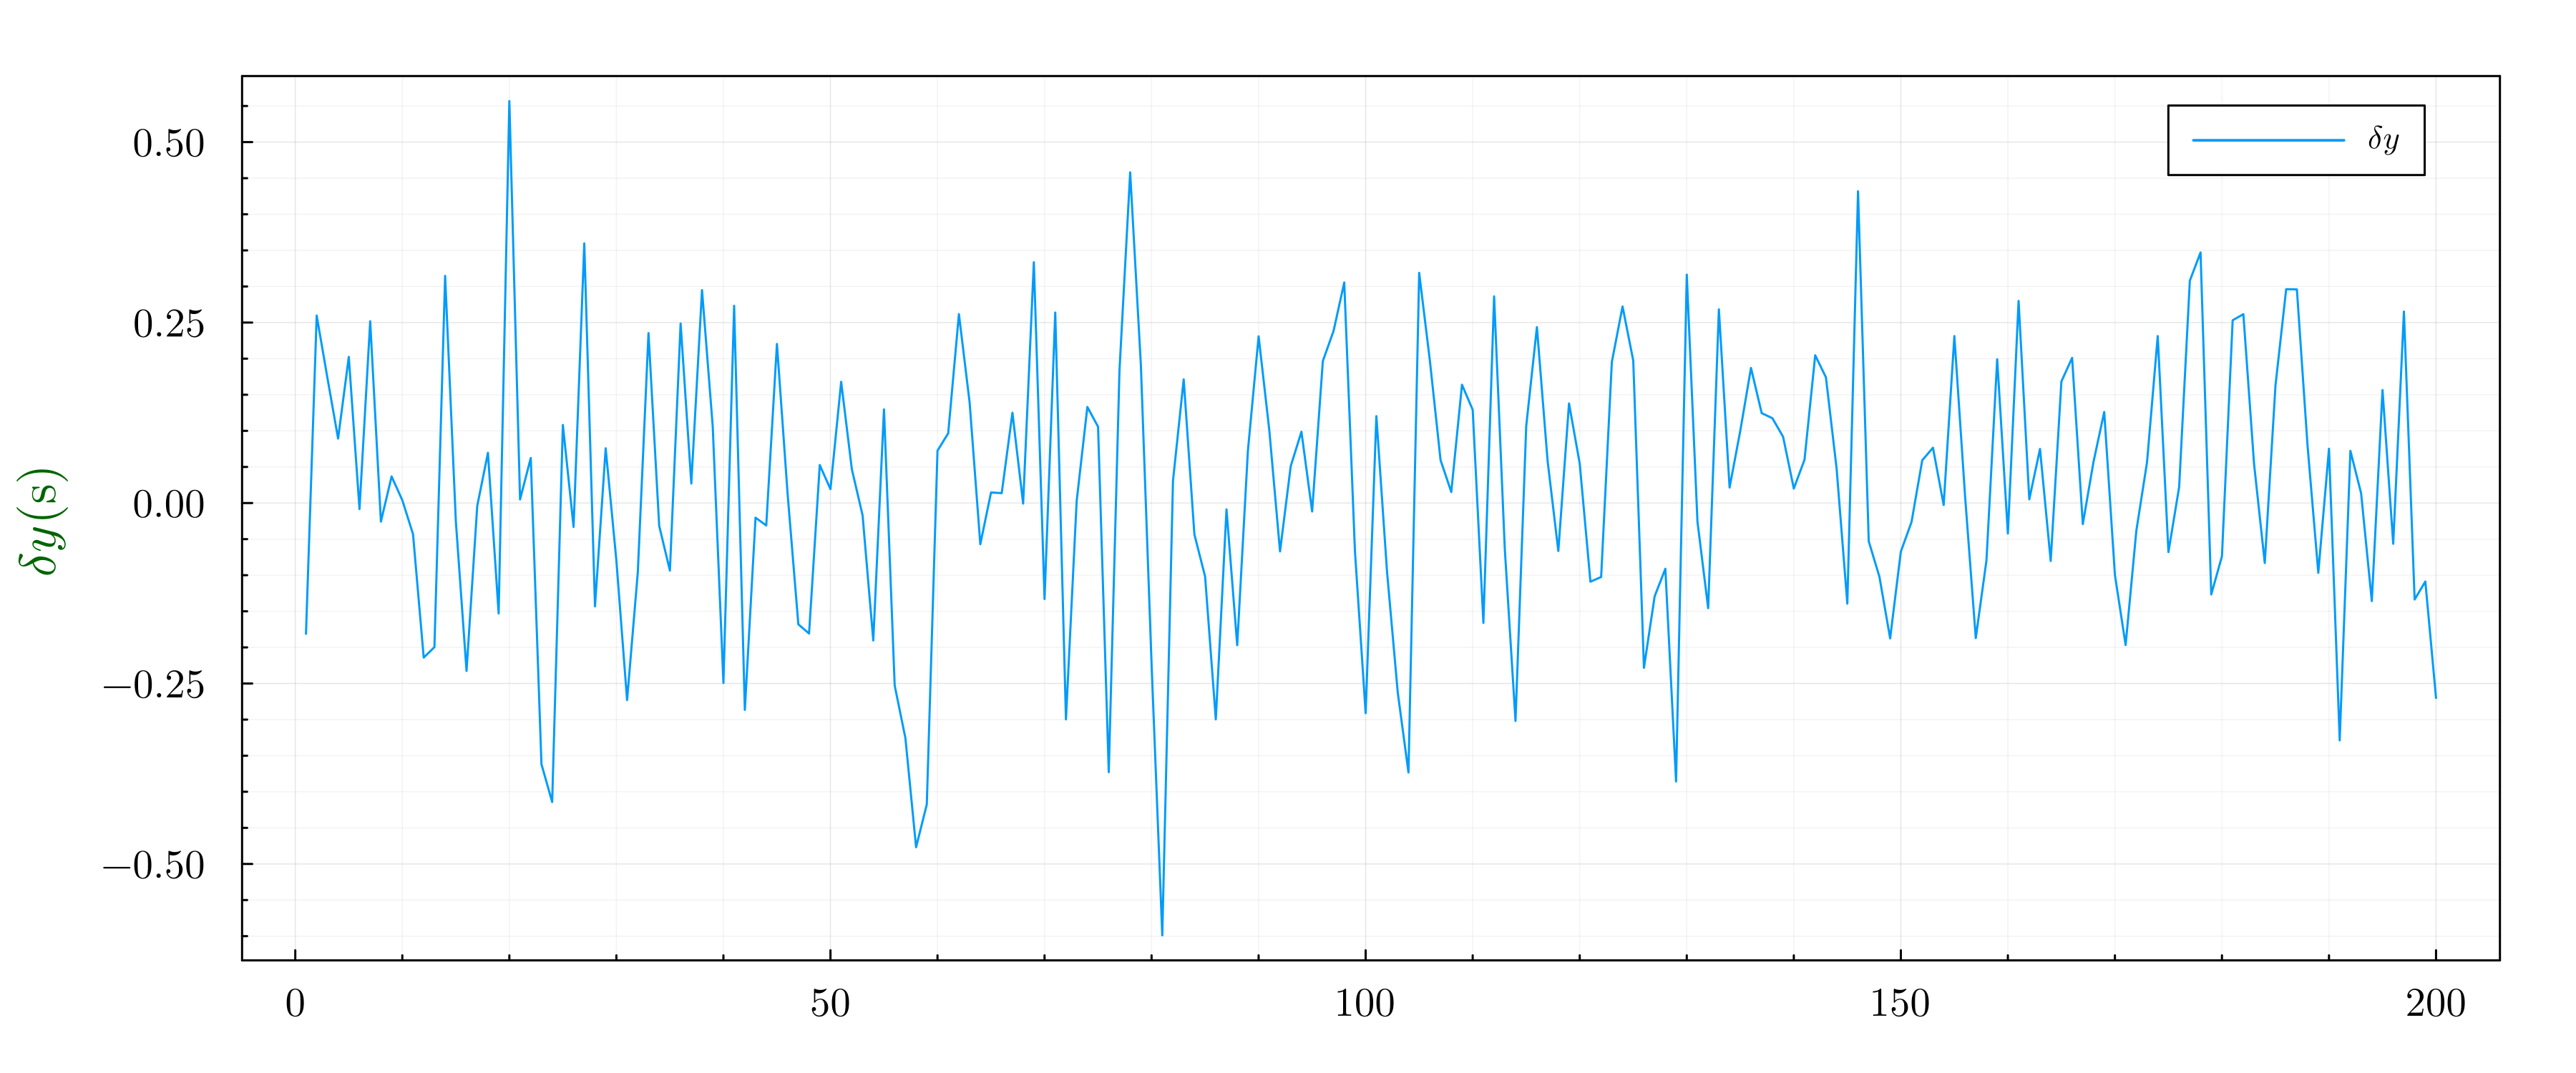

In [5]:
plot(δy, size=(1200,500), ylabel=L"\delta y\,\mathrm{(s)}", label=L"\delta y")

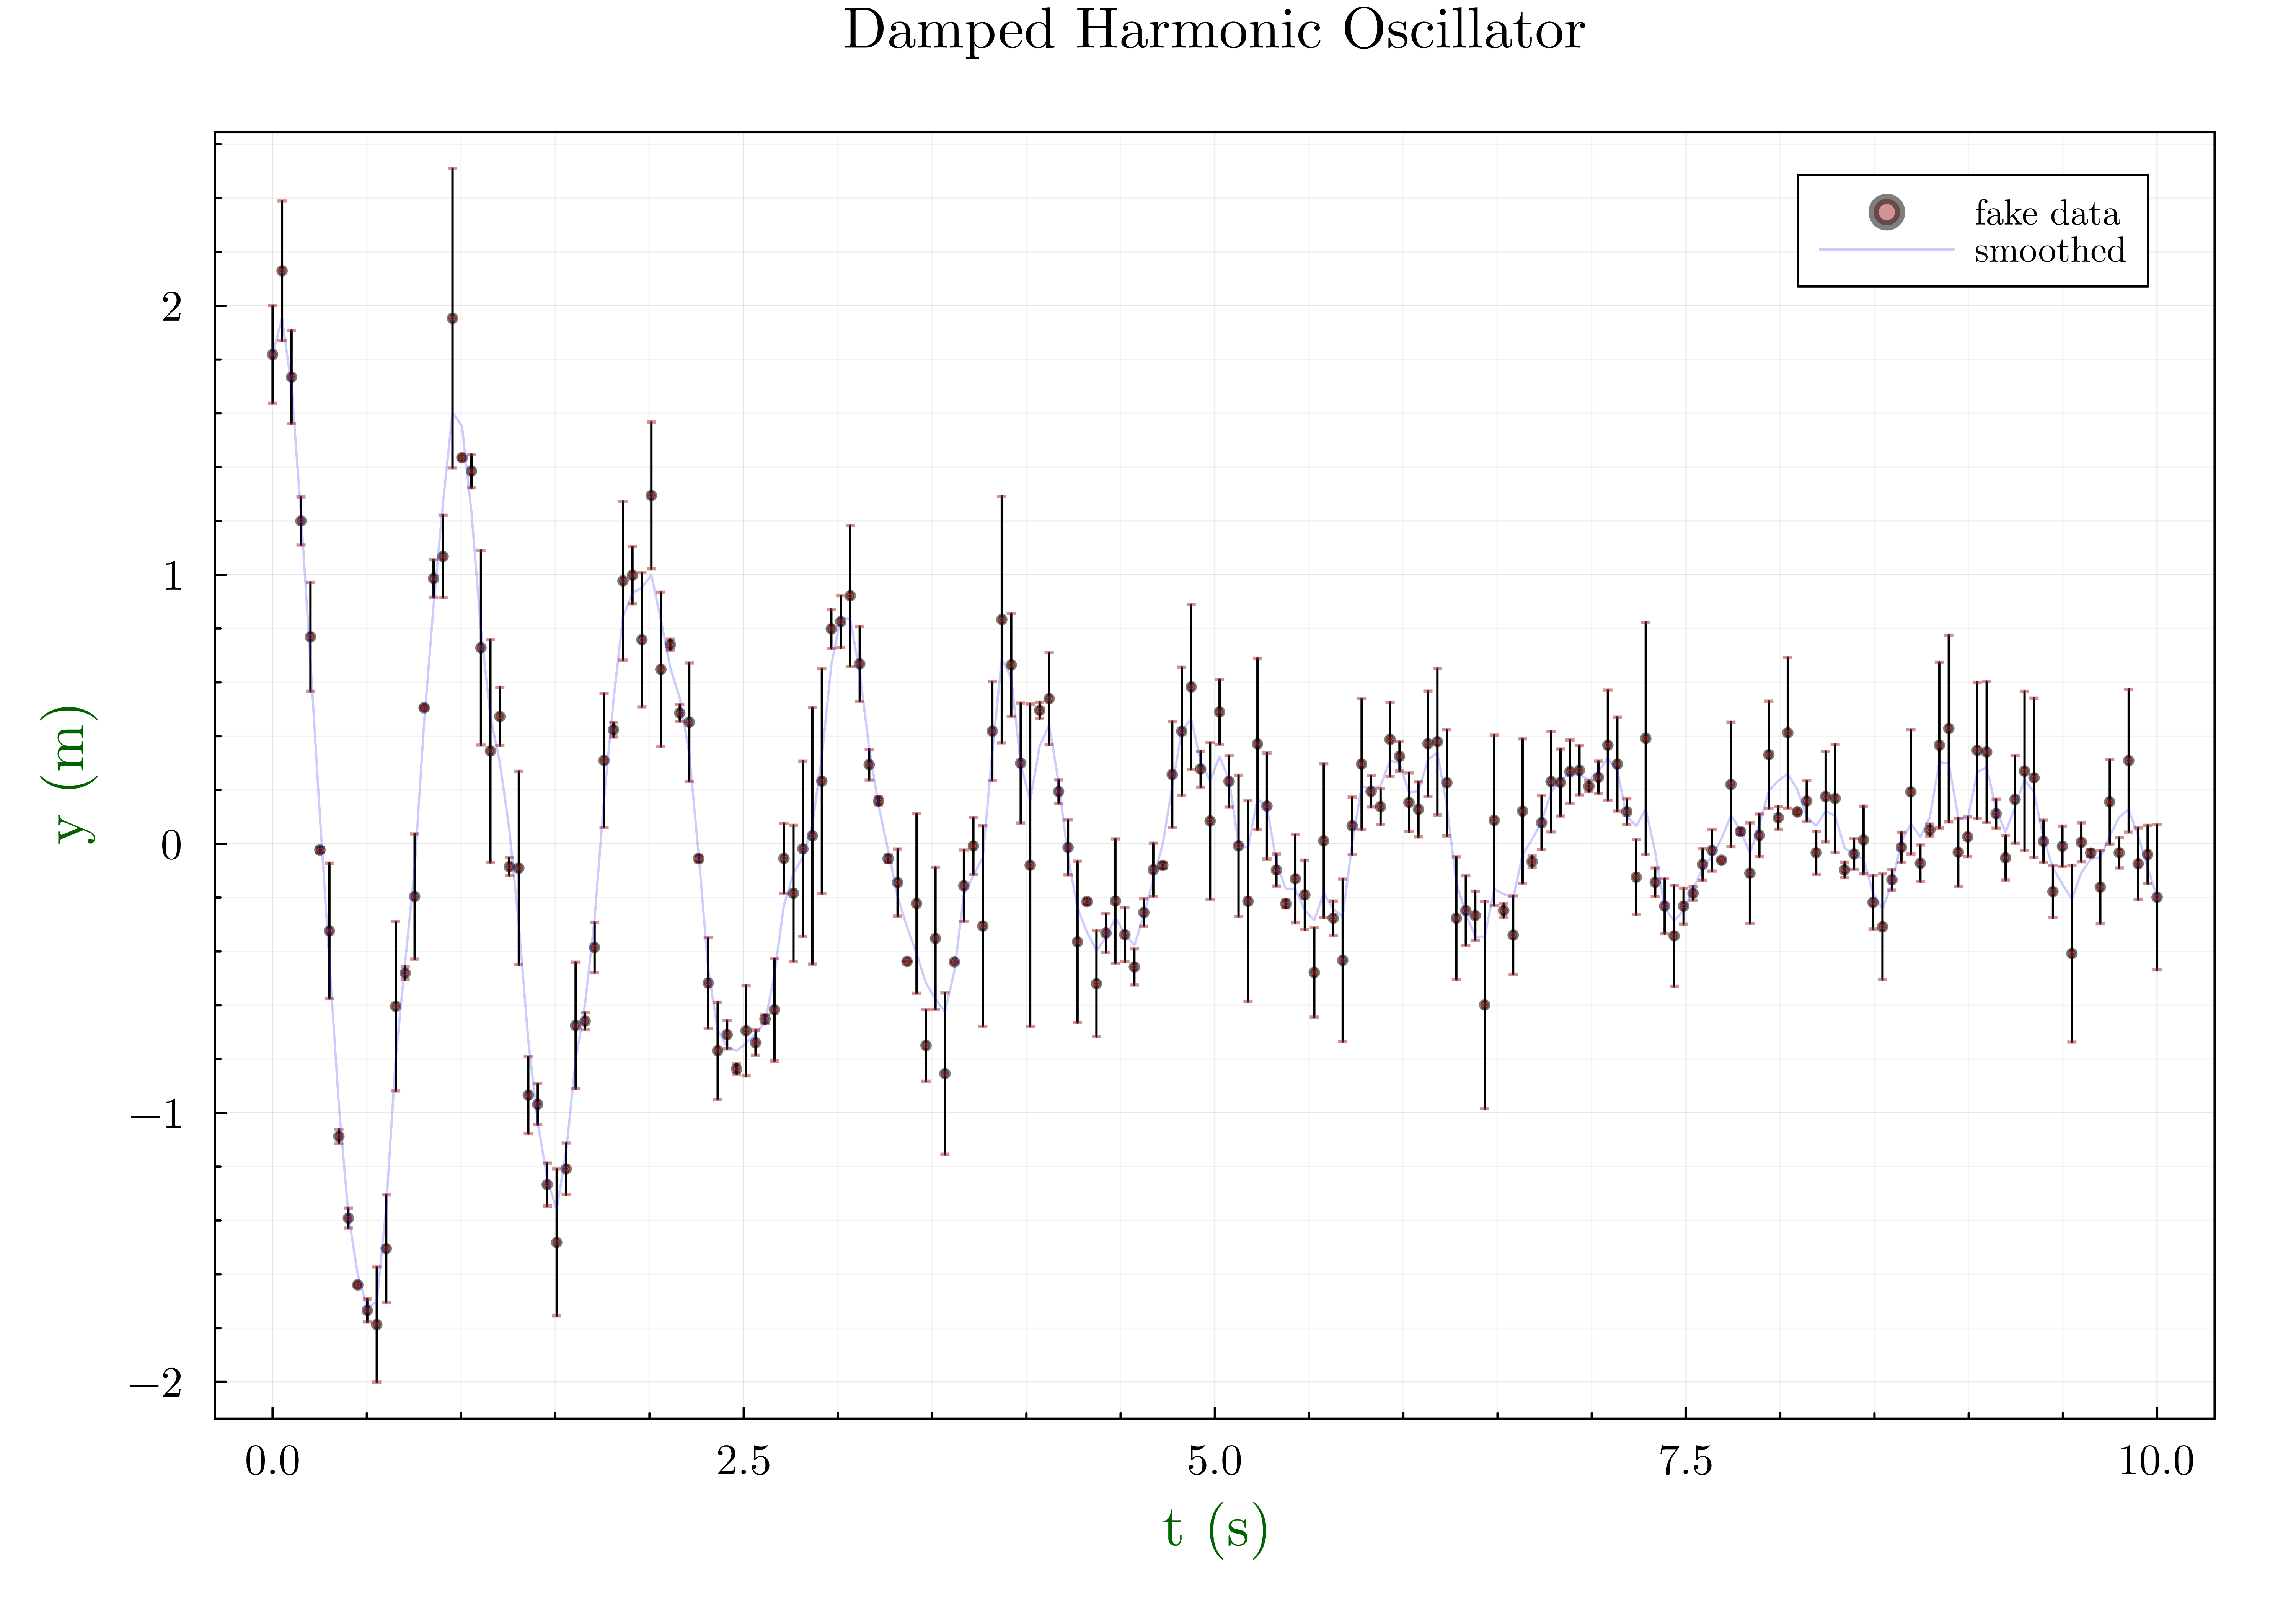

In [6]:
scatter(tdata, ydata, xerr=δt, yerr=δy, marker=:circle, markersize=2, markeralpha=0.5,
     markercolor=:brown, label = "fake data", xlabel = "t (s)", ylabel = "y (m)", 
     title = "Damped Harmonic Oscillator", legend = :topright, dpi=600, size=(1000,700))
plot!(tdata, Smoothing.binomial(ydata,1), label="smoothed", alpha=0.2, color=:blue)

In [7]:
savefig("SHO_data.png")

"/Users/paulnakroshis/Code/DataFit/docs/SHO_data.png"

Now, we have to find the fit parameters and the covariance matrix:

## fit the data and return fit params

In [8]:
"""
fit_data(model, tdata, ydata, p0)

Fit the model function `model` to the data `ydata` at time points `tdata`
using initial parameters `p0`.

# Arguments
- `model::Function`: The model function to fit.
- `tdata::Vector`: A vector of time points.
- `ydata::Vector`: A vector of corresponding data points.
- `p0::Vector`: A vector of initial parameter values.

# Returns
A tuple `(fit_params, σ)` of the fitted parameter values and their standard deviations.

# Example
```julia
model(x, p...) = p[1] .* exp.(-p[2] .* x) .* sin.(p[3] .* x .+ p[4])
tdata = range(0, 10, length=100)
ydata = model(tdata, 1.0, 0.5, 2π, π/2) + randn(size(tdata))
p0 = [1.0, 1.0, 2π, π/2]
fit_params, σ = fit_data(model, tdata, ydata, p0)
"""
function fit_data(model, tdata, ydata, p0)
    fit = curve_fit(model, tdata, ydata, p0)
    fit_params = fit.param
    σ = stderror(fit)
    return fit_params, σ # returns a tuple of fit parameters and their standard deviations
end

fit_data

In [9]:
p0, σ0 = fit_data(model, tdata, ydata, p0)
println(round.(p0; digits=4))
println(round.(σ0; digits=4))

[2.0431, 2.9332, 6.2985, -0.0362]
[0.0702, 0.1474, 0.0177, 0.0362]


## Model uncertainty via bootstrap method
I'll estimate the model uncertainty by the following method: <br>
1. Create a bootstrapped data set:<br> At each data sample time $t_i$, with data points $y(t_i)$,
choose a set of values $[y^{\prime}_1, y^{\prime}_2 \ldots, y^{\prime}_N]$ by  selecting a value  
from a Gaussian distribution of width $\Delta y_i$ centered each $y_i$.  <br>
2. Then compute the best fit parameters and repeat this a large number, $m_{\mathrm{samples}}$ of times. 
3. Compute the standard deviation of the best fit model values, and this give us the bootstrapped $1\sigma_B$ uncertainties on the model parameters. 

In [10]:
# analyze spacing bewteen elements of a Vector
function spacing_info(v::Vector, full_stats::Bool=false)
    Δt =v[2:end] - v[1:end-1]
    if any(Δt .<= 0)
        error("Vector must be strictly increasing. 
              Your generated bootstrap array is not time ordered. 
              try reducing the number of standard deviations used in 
                  your gaussian sample")
    end
    Δtmin = minimum(Δt)
    if full_stats
        Δtmax = maximum(Δt)
        Δtmean = mean(Δt)
        Δtstd = std(Δt)
        return round.([Δtmin, Δtmax, Δtmean, Δtstd]; digits=6)
    else
        return round(Δtmin; digits=6)
    end
end

spacing_info (generic function with 2 methods)

In [11]:
function bootstrap_fit(model, tdata, δt, Σt, ydata, δy, Σy, p0, m_samples)
    fit_params, σ = fit_data(model, tdata, ydata, p0)
    fit_params_array = zeros(length(fit_params), m_samples)
    
    for i in 1:m_samples
        t_boot = rand.(Normal.(tdata, abs.(Σt*δt))) # create bootstrap time data
        if spacing_info(t_boot) ≥ 0.0
            y_boot = rand.(Normal.(ydata, abs.(Σy*δy))) # create bootstrap y data
            fit_params_array[:,i] = fit_data(model, t_boot, y_boot, p0)[1]
        else
            error("Vector must be strictly increasing. 
              Your generated bootstrap array is not time ordered. 
              try reducing the number of standard deviations used in 
                  your gaussian sample")
        end
    end
    p  = vec(mean(fit_params_array, dims=2))
    σₚ =vec(std(fit_params_array, dims=2))
    return p, σₚ
end

bootstrap_fit (generic function with 1 method)

In [12]:
p, σₚ = bootstrap_fit(model, tdata, δt, 1, ydata, δy,1, p0, 1000)
println("p = ", round.(p; digits=4))
println("σₚ = ", round.(σₚ; digits=4))

p = [2.0436, 2.943, 6.2988, -0.0374]
σₚ = [0.072, 0.1584, 0.0165, 0.0341]


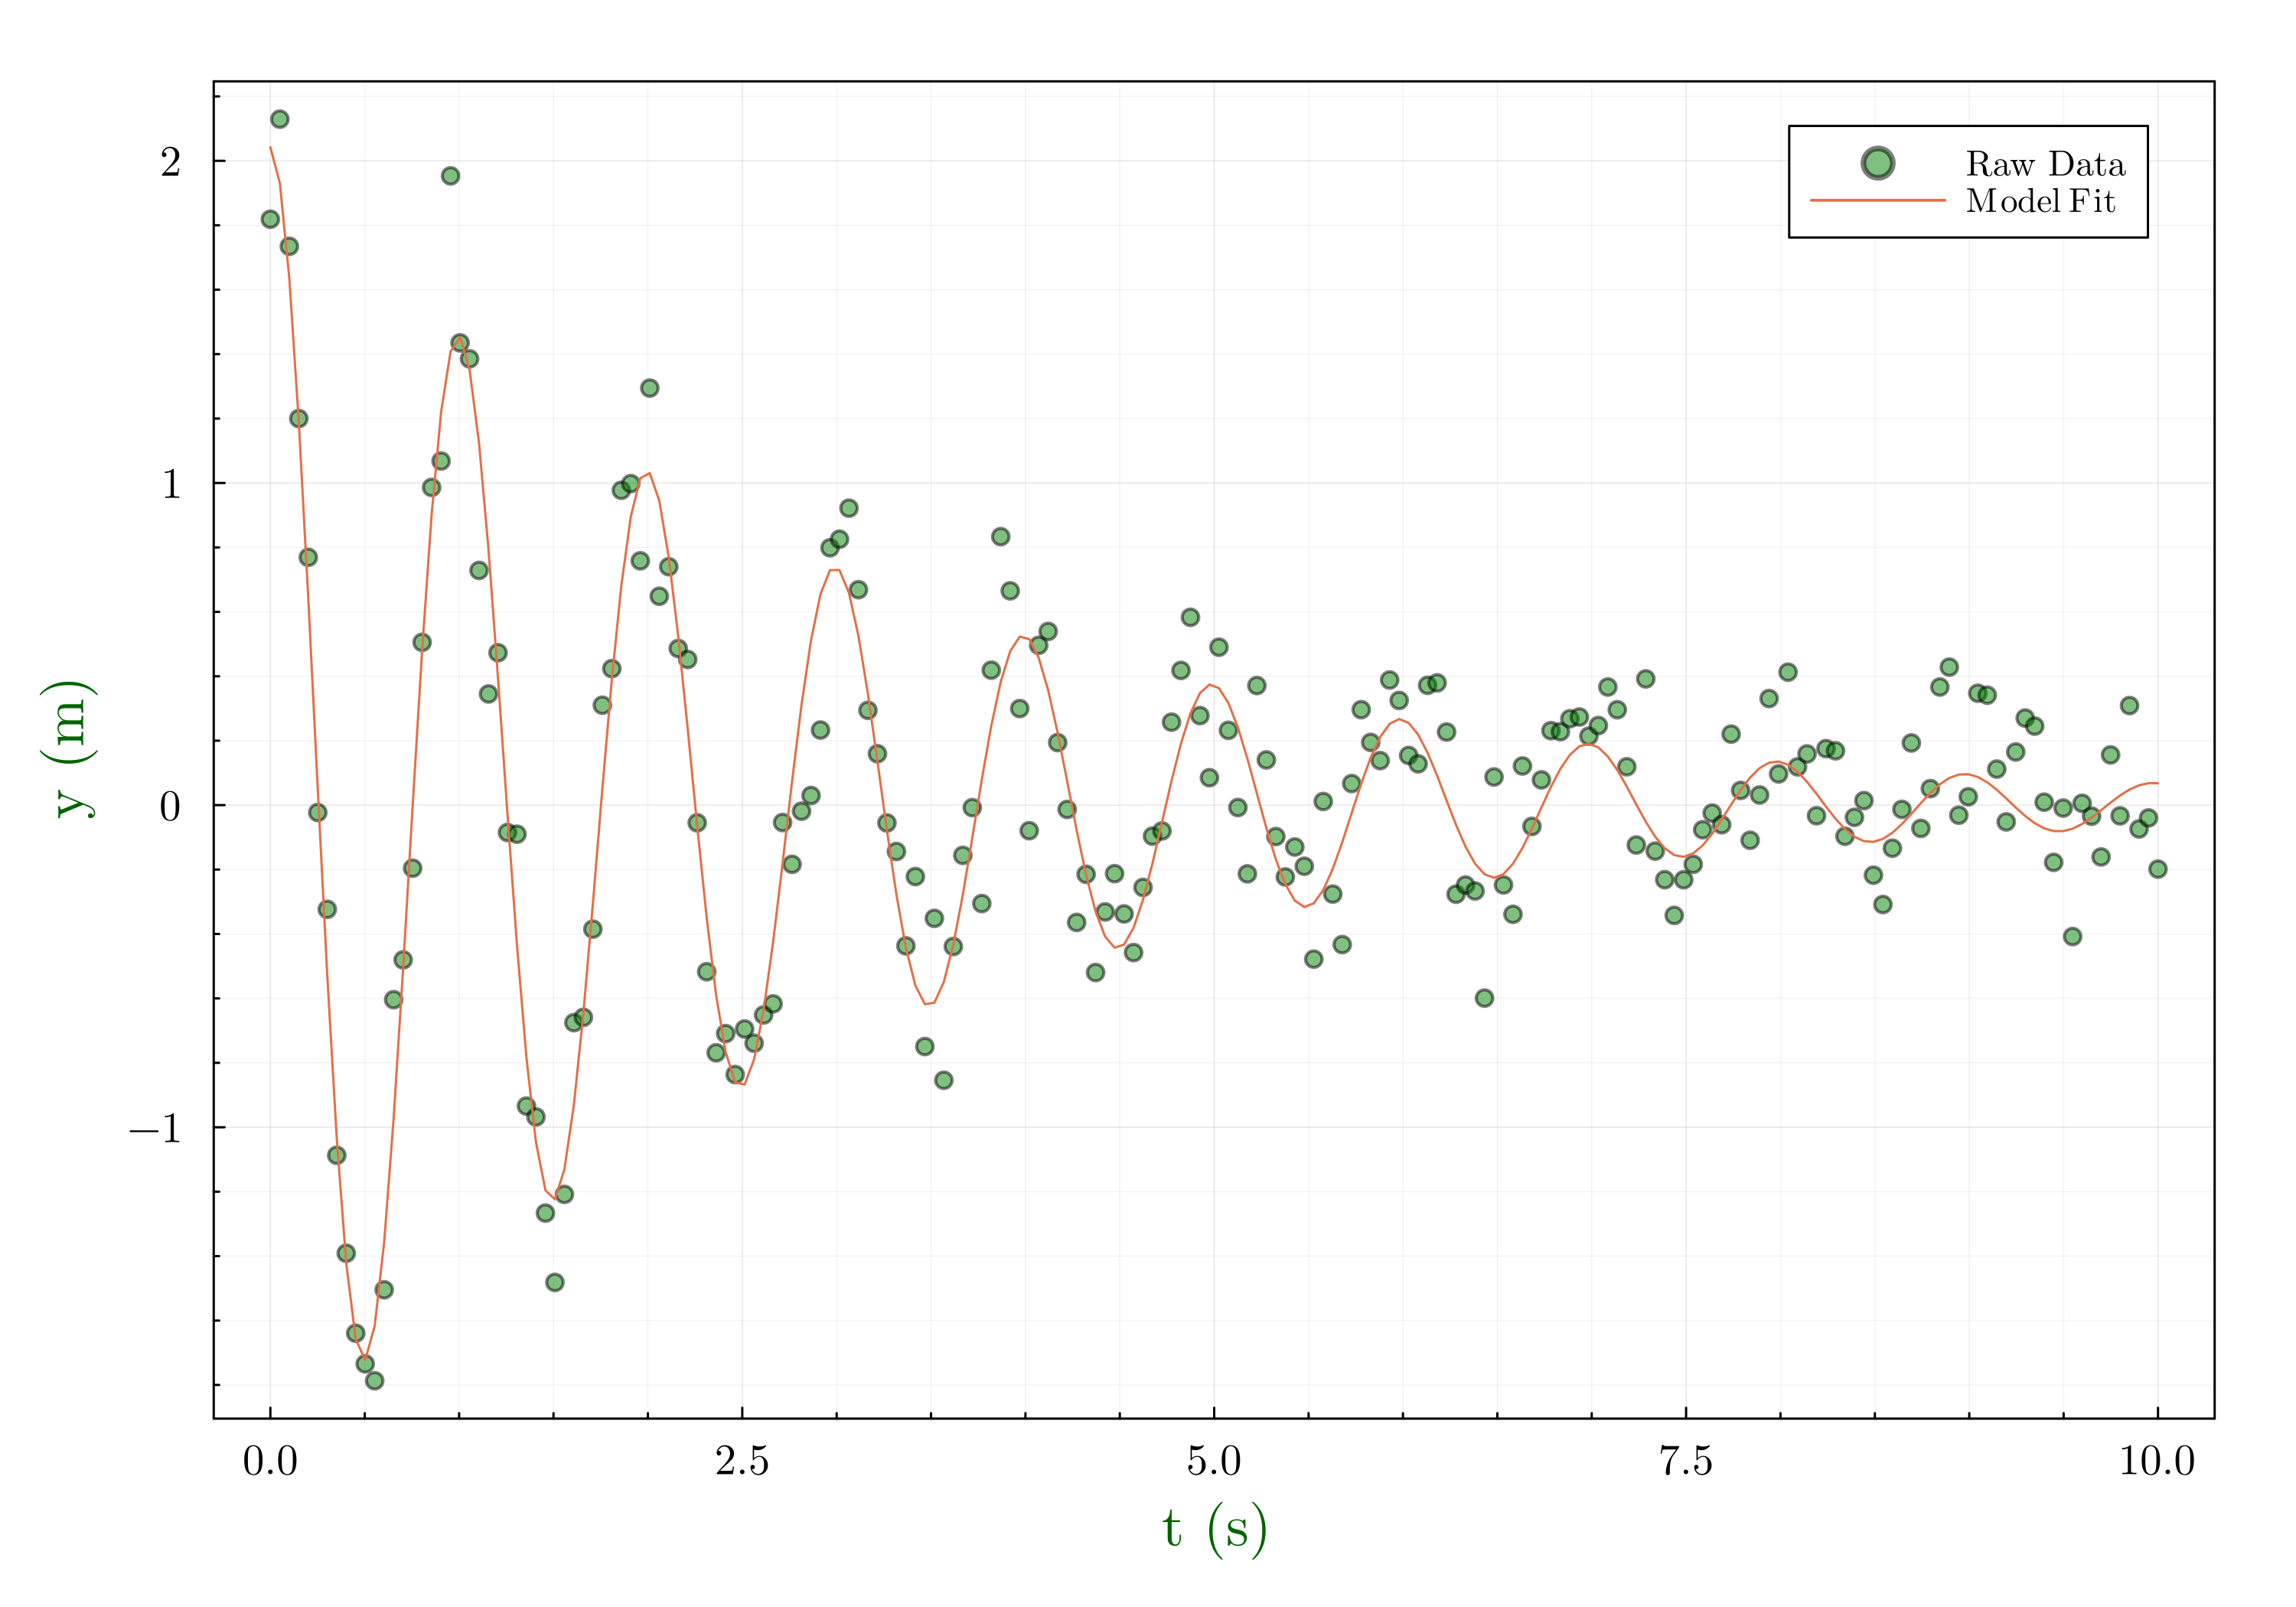

In [13]:
scatter(tdata, ydata, alpha=0.5, color=:green, label="Raw Data", size=(1000,700),  xlabel = "t (s)", ylabel = "y (m)")
#plot!(tdata, Smoothing.binomial(ydata, 1), alpha=0.6, color=:darkred, label="Smoothed")
plot!(tdata,  model(tdata,p), label=L"$\mathrm{Model\;Fit}$")      

## How to incorporate the fit parameter uncertainties
In order to plot the effect of the model parameter uncertainties as determined by the bootstrapped method, we need to know the uncertainties effect the model fit value.
This, in general, is not trivial, until you realize that the way to compute the largest possible value of the model, we need to only evaluate the partial derivative of the model with respect to the parameter of interest evaluate at the data point being considered. 

The model in this notebook is 
```julia
model(t, p) = p[1] * exp.(-t./p[2]) .* cos.(p[3]*t .+ p[4]) 
```

https://discourse.julialang.org/t/color-for-each-bar-in-a-bar-plot/68420



In [14]:
function Δp(model, tᵢ, p, σₚ, α)
    # find partial derivatives with respect to parameters of model
    ∂pᵢ = zeros(length(p))
    ϵij = α*Diagonal(ones(length(p)))
    p₊ = Matrix{Float64}(undef, length(p), length(p))
    p₋ = Matrix{Float64}(undef, length(p), length(p))
    for i in 1:length(p)
        p₊[i, : ] = p .+ ϵij[i, :].*σₚ[i]
        p₋[i, : ] = p .-  ϵij[i, :].*σₚ[i]
        ∂pᵢ[i] = (model(tᵢ, p₊[i, :]) .- model(tᵢ, p₋[i, : ]))/(2*α.*σₚ[i])
    end
    return ∂pᵢ
end

# numerical partial derivative for the model with respect to the parameters at time tᵢ
function uncertainty(model, t::Vector, σₜ::Vector, p::Vector, σₚ::Vector, α=1e-6)
    Δy = zeros(length(t))
    for i in 1:length(t)
        if i==1
            ∂ₜ = (model(t[i] + α*σₜ[i], p) - model(t[i],p))/(α*σₜ[i])
            ∂ₚ = Δp(model, t[i], p, σₚ, α)
            Δy[i] = sqrt((∂ₜ*σₜ[i])^2 + sum((∂ₚ .* σₚ).^2))
        elseif i<length(t)
            ∂ₜ = (model(t[i] + α*σₜ[i], p) - model(t[i]-α*σₜ[i],p))/(2*α*σₜ[i])
            ∂ₚ = Δp(model, t[i], p, σₚ, α)
            Δy[i] = sqrt((∂ₜ*σₜ[i])^2 + sum((∂ₚ .* σₚ).^2))
        else
            ∂ₜ = (model(t[i], p) - model(t[i]-α*σₜ[i],p))/(α*σₜ[i])
            ∂ₚ = Δp(model, t[i], p, σₚ, α)
            Δy[i] = sqrt((∂ₜ*σₜ[i])^2 + sum((∂ₚ .* σₚ).^2))
        end
    end
    return Δy
end

uncertainty (generic function with 2 methods)

The uncertainty in the model at each time $t_i$, $\Delta y(t\_i)$, can be obtained by adding the errors in quadrature; i.e.

$$ \Delta y(t_i) =  \sqrt{\left(\frac{\partial y}{\partial t}\sigma_t\right)^2 + \sum_{j=1}^N \left(\frac{\partial y}{\partial p_j} \sigma_{p_j}\right)^2}, $$

where the number of model parameters is $N$. 

In [15]:
p, σₚ = bootstrap_fit(model, tdata, δt, 1, ydata, δy,5, p0, 2000)
println("p = ", round.(p; digits=4))
println("σₚ = ", round.(σₚ; digits=4))

p = [2.0857, 3.1053, 6.296, -0.0324]
σₚ = [0.3631, 0.8734, 0.0933, 0.1641]


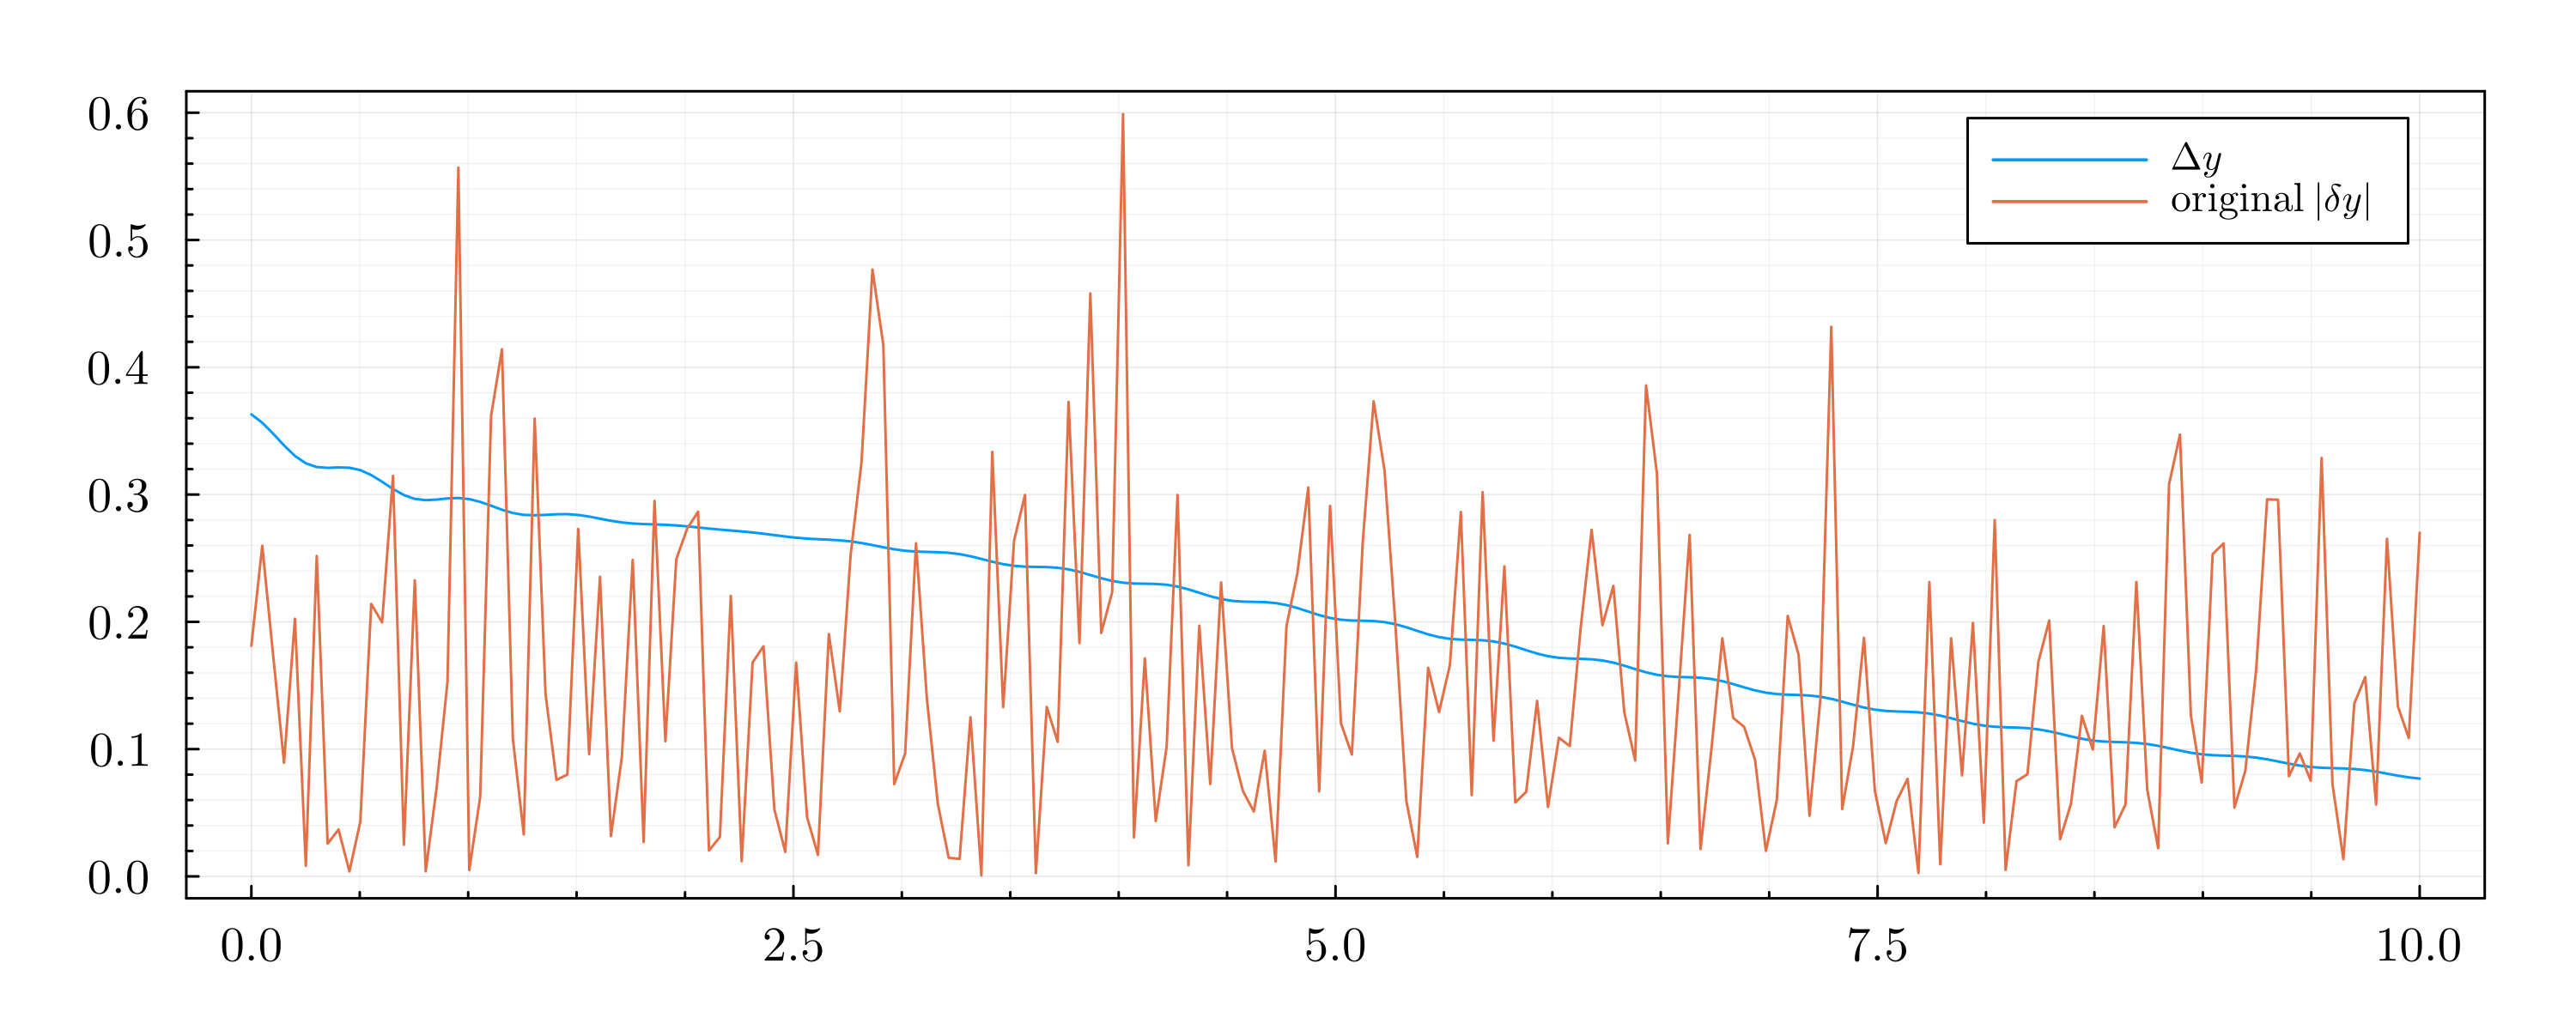

In [16]:
Δy_boot = uncertainty(model, tdata,δt, p, σₚ, 1e-6);
plot(tdata ,Δy_boot, size=(1000,400), label=L"Δy")
plot!(tdata,abs.(δy), label=L"original $|\delta y|$")

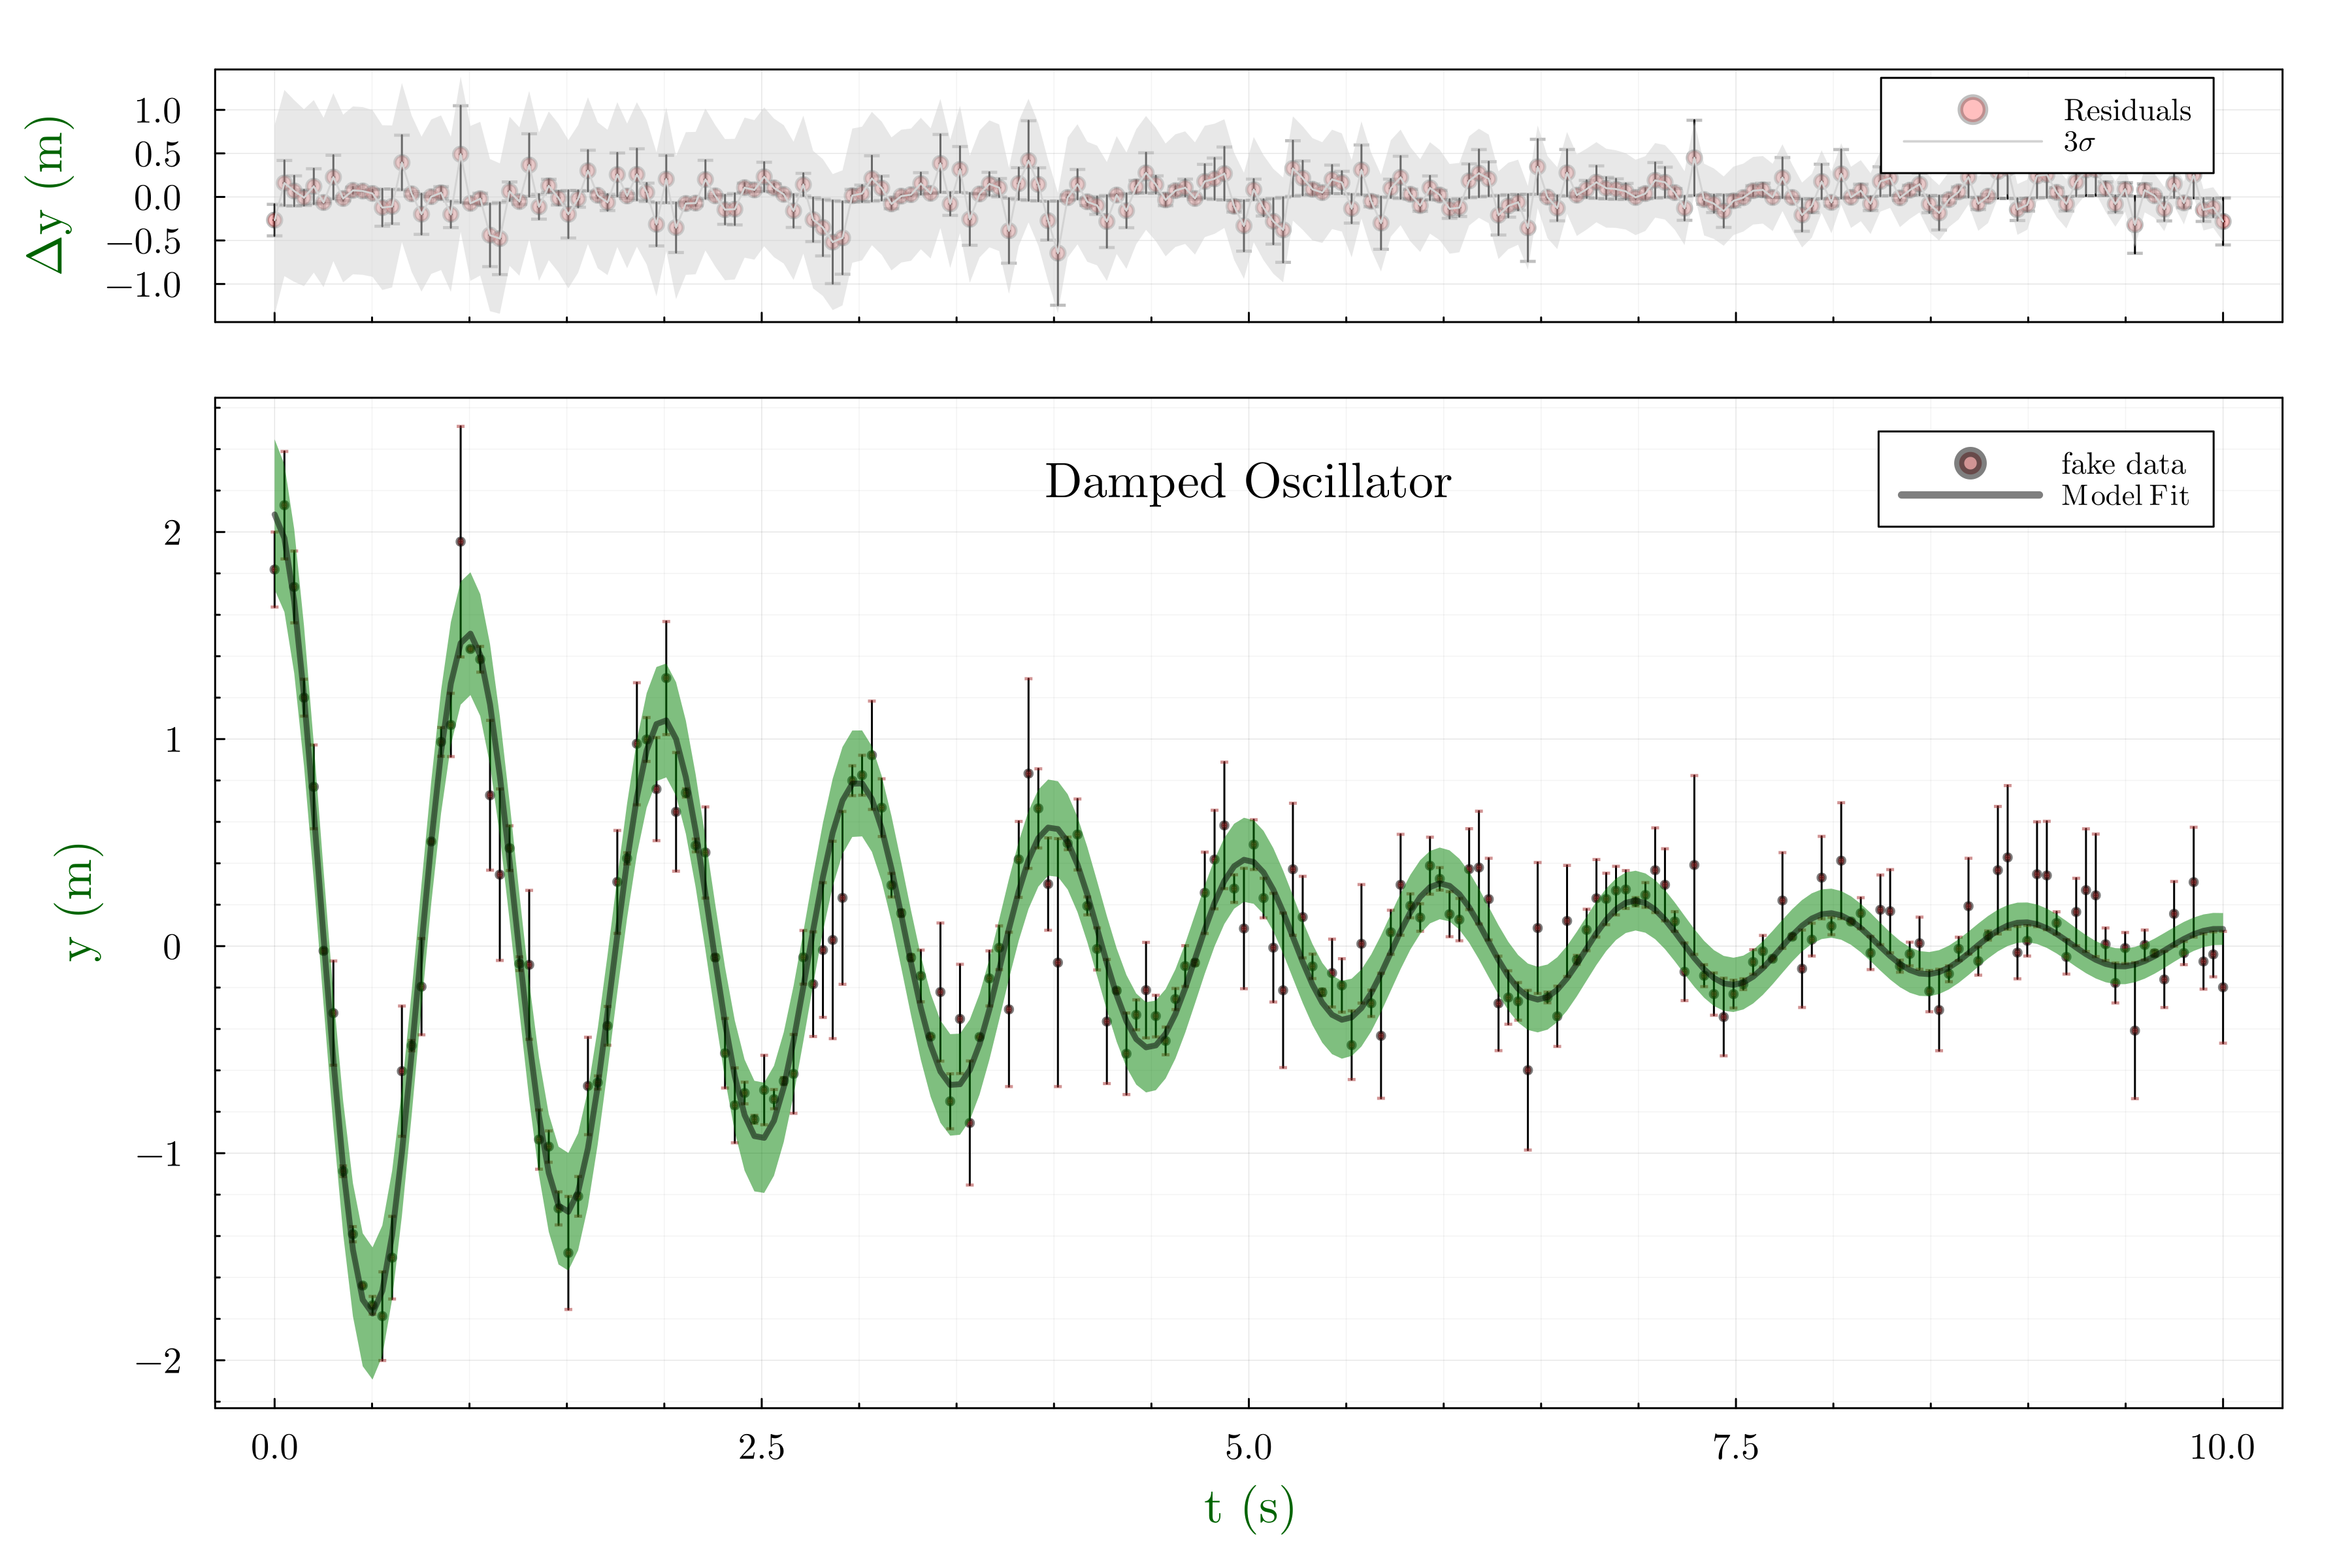

In [18]:
plot1 = scatter(tdata, ydata, xerr=δt, yerr=δy, marker=:circle, markersize=2, markeralpha=0.5,
     markercolor=:brown, label = "fake data", xlabel = "t (s)", ylabel = "y (m)", 
     title = "Damped Oscillator", legend = :topright, dpi=600, top_margin=-15mm)
#scatter(tdata, ydata, alpha=0.5, color=:green, label="Raw Data", size=(900,350),  xlabel = "t (s)", ylabel = "y (m)")
#plot!(tdata, Smoothing.binomial(ydata, 1), alpha=0.6, color=:darkred, label="Smoothed")
plot!(tdata,  model(tdata,p), ribbon=Δy_boot, label="", color=:green, alpha=0.1)
plot!(tdata,  model(tdata,p), label=label=L"$\mathrm{Model\;Fit}$", linewidth=3, color = :black, alpha=0.5)


plot2 = scatter(tdata, ydata .- model(tdata,p), color=:red, label="Residuals", 
         xlabel =" ", ylabel = "Δy (m)",
        xerr=δt,yerr=δy,  marker=:circle, markersize=4, markeralpha=0.25,
        xformatter=_->"", yminorgrid=false)
plot!(tdata, ydata .- model(tdata,p), ribbon=3*Δy_boot, color=:lightgray, label=L"3\sigma")

plot(plot2, plot1, layout=grid(2, 1, heights=[0.2 ,0.8], link=:x, margin=10mm))

In [89]:
savefig("Damped_fit.png")

"/Users/pauln/Dropbox/DocumentsF/Github/DataFit.jl/docs/Damped_fit.png"

In [32]:
savefig("data_and_fit.png")

"/Users/pauln/Dropbox/DocumentsF/Github/docs/data_and_fit.png"

# Tests
## Linear fit with noise

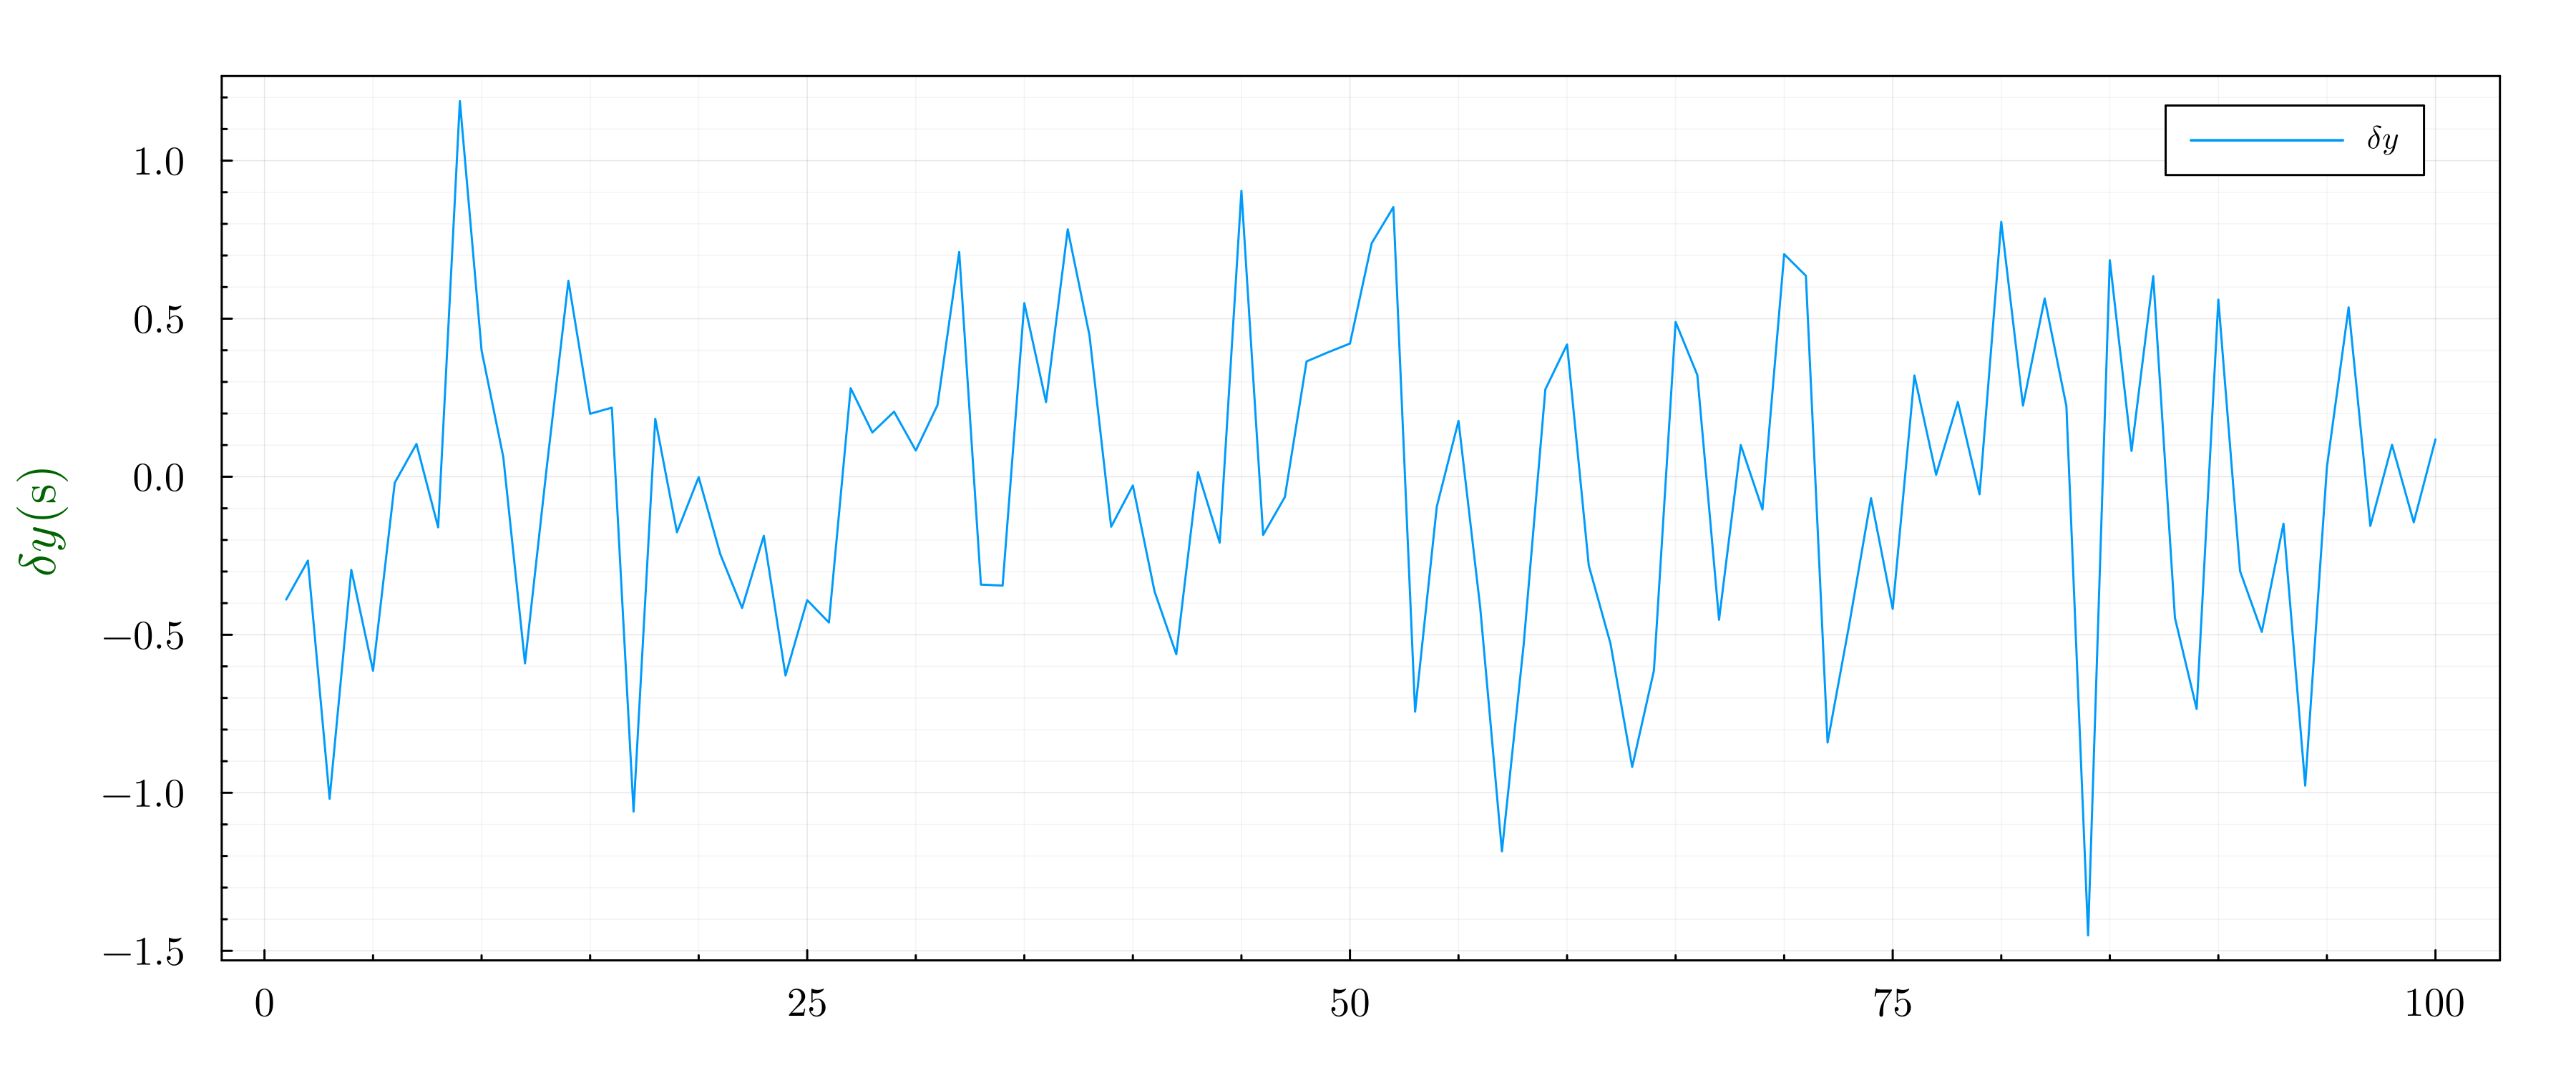

In [19]:
linear(t,p) = p[1] .+ p[2].*t
tmin, tmax, N_times = 0.0, 10.0, 100
Δy = 0.5
dt = (tmax-tmin)/N_times
tdata = collect(LinRange(tmin,tmax,N_times))
δt = 0.1*dt*ones(length(tdata))
δy = rand(Normal(0, Δy),length(tdata))
ydata = linear(tdata, [10.0, 4.0]) .+ δy
#initial guess for fit:
p0 = [0.5, 3.0];
plot(δy, size=(1200,500), ylabel=L"\delta y\,\mathrm{(s)}", label=L"\delta y")

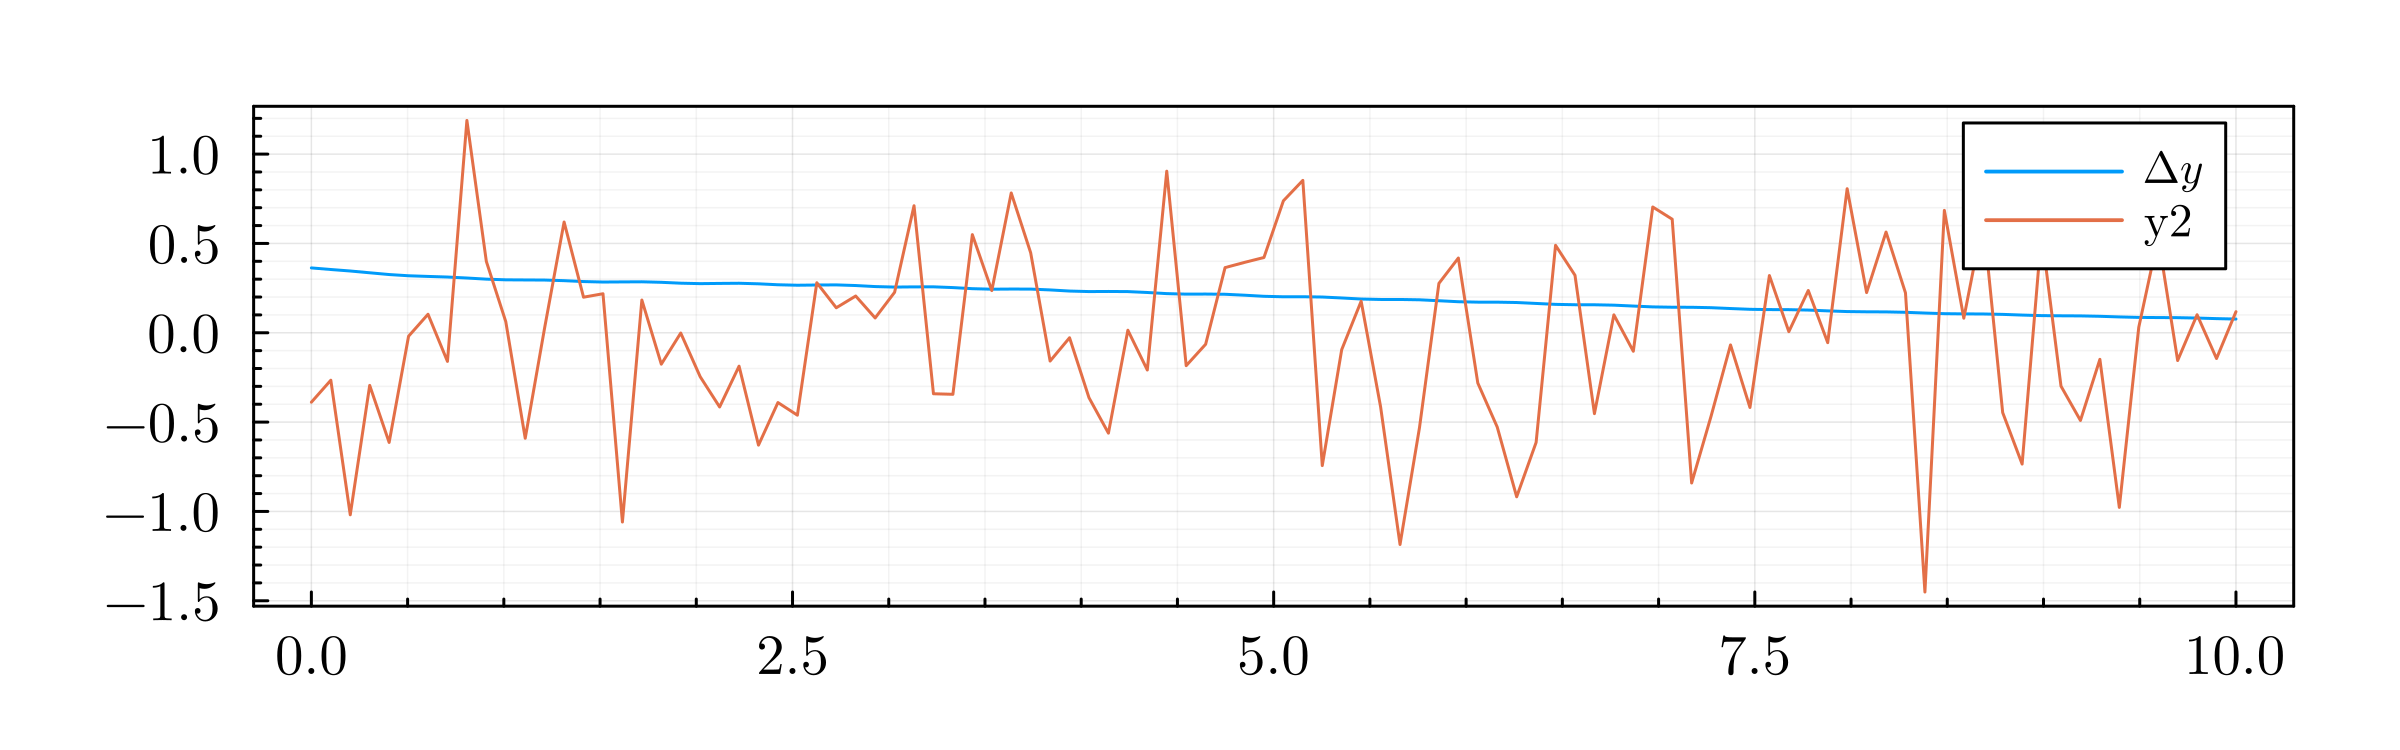

In [20]:
Δy_boot = uncertainty(model, tdata,δt, p, σₚ, 1e-6);
plot(tdata ,Δy_boot, size=(800,250), label=L"Δy")
plot!(tdata,δy)

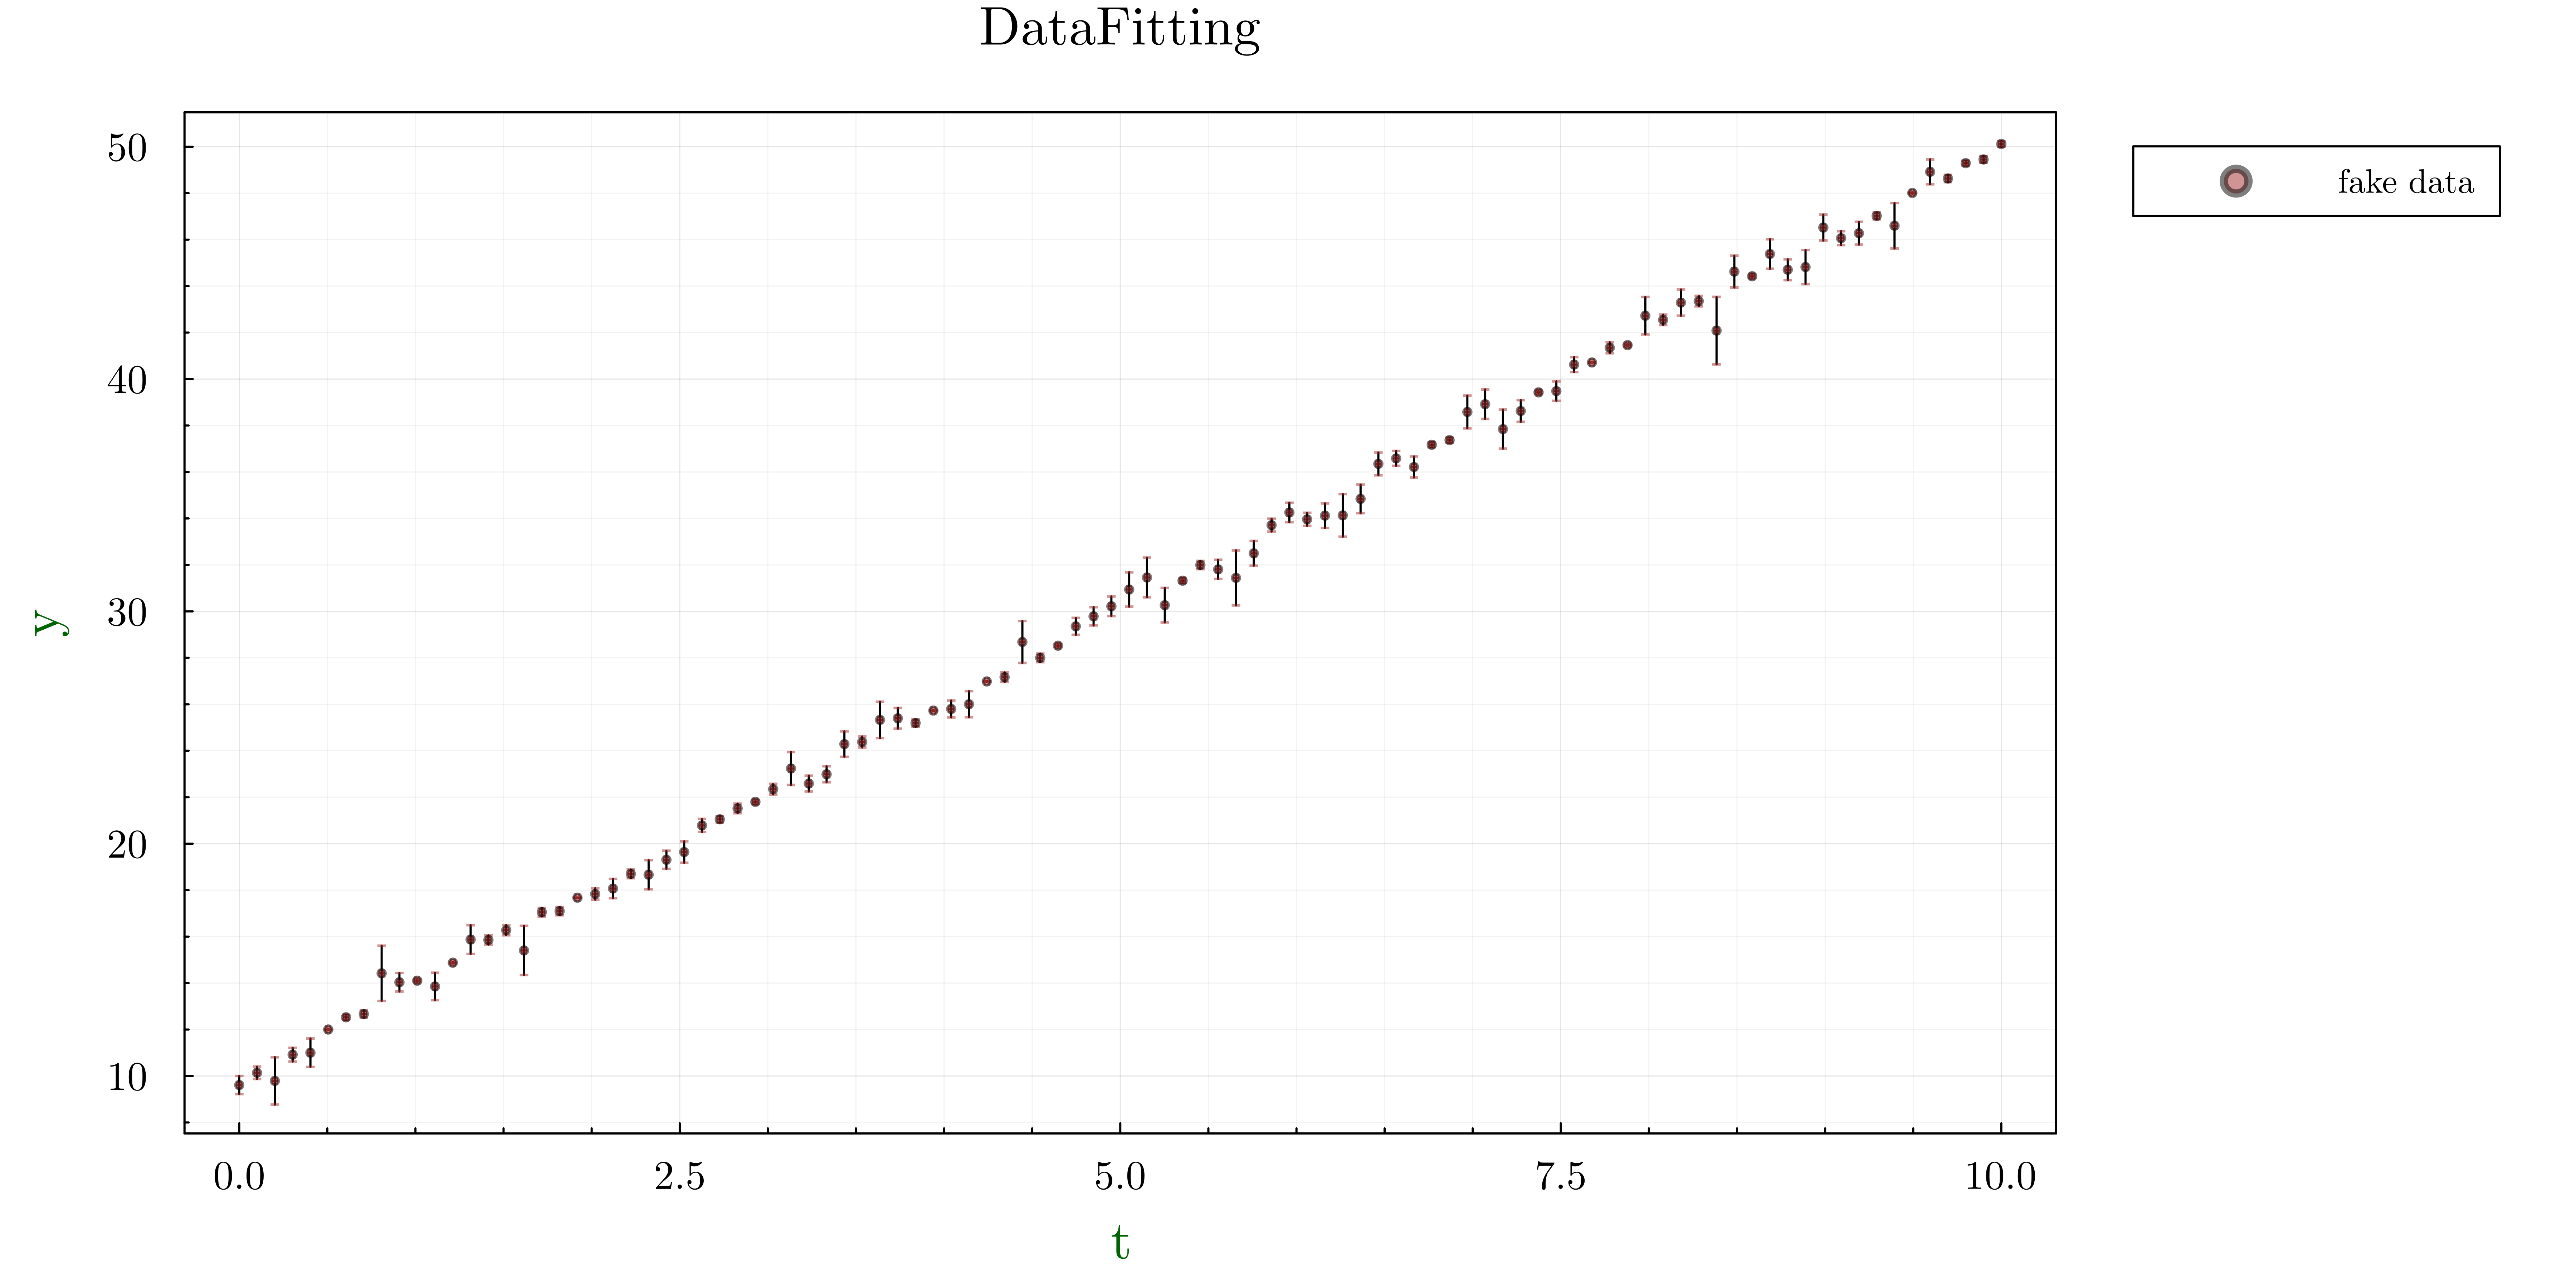

In [21]:
scatter(tdata, ydata, xerr=δt, yerr=δy, marker=:circle, markersize=2, markeralpha=0.5,
     markercolor=:brown, label = "fake data", xlabel = "t", ylabel = "y", 
     title = "DataFitting", legend = :outertopright, dpi=600, size=(1200,600))

In [22]:
pf, σf = fit_data(linear, tdata, ydata, p0)
println("Best Fit parameters (not including uncertainties):")
println(round.(pf; digits=4))
println(round.(σf; digits=4))

Best Fit parameters (not including uncertainties):
[9.9464, 4.0045]
[0.1008, 0.0174]


Bootstrapped fit values:
p = [9.9476, 4.0041]
σₚ = [0.0952, 0.0172]


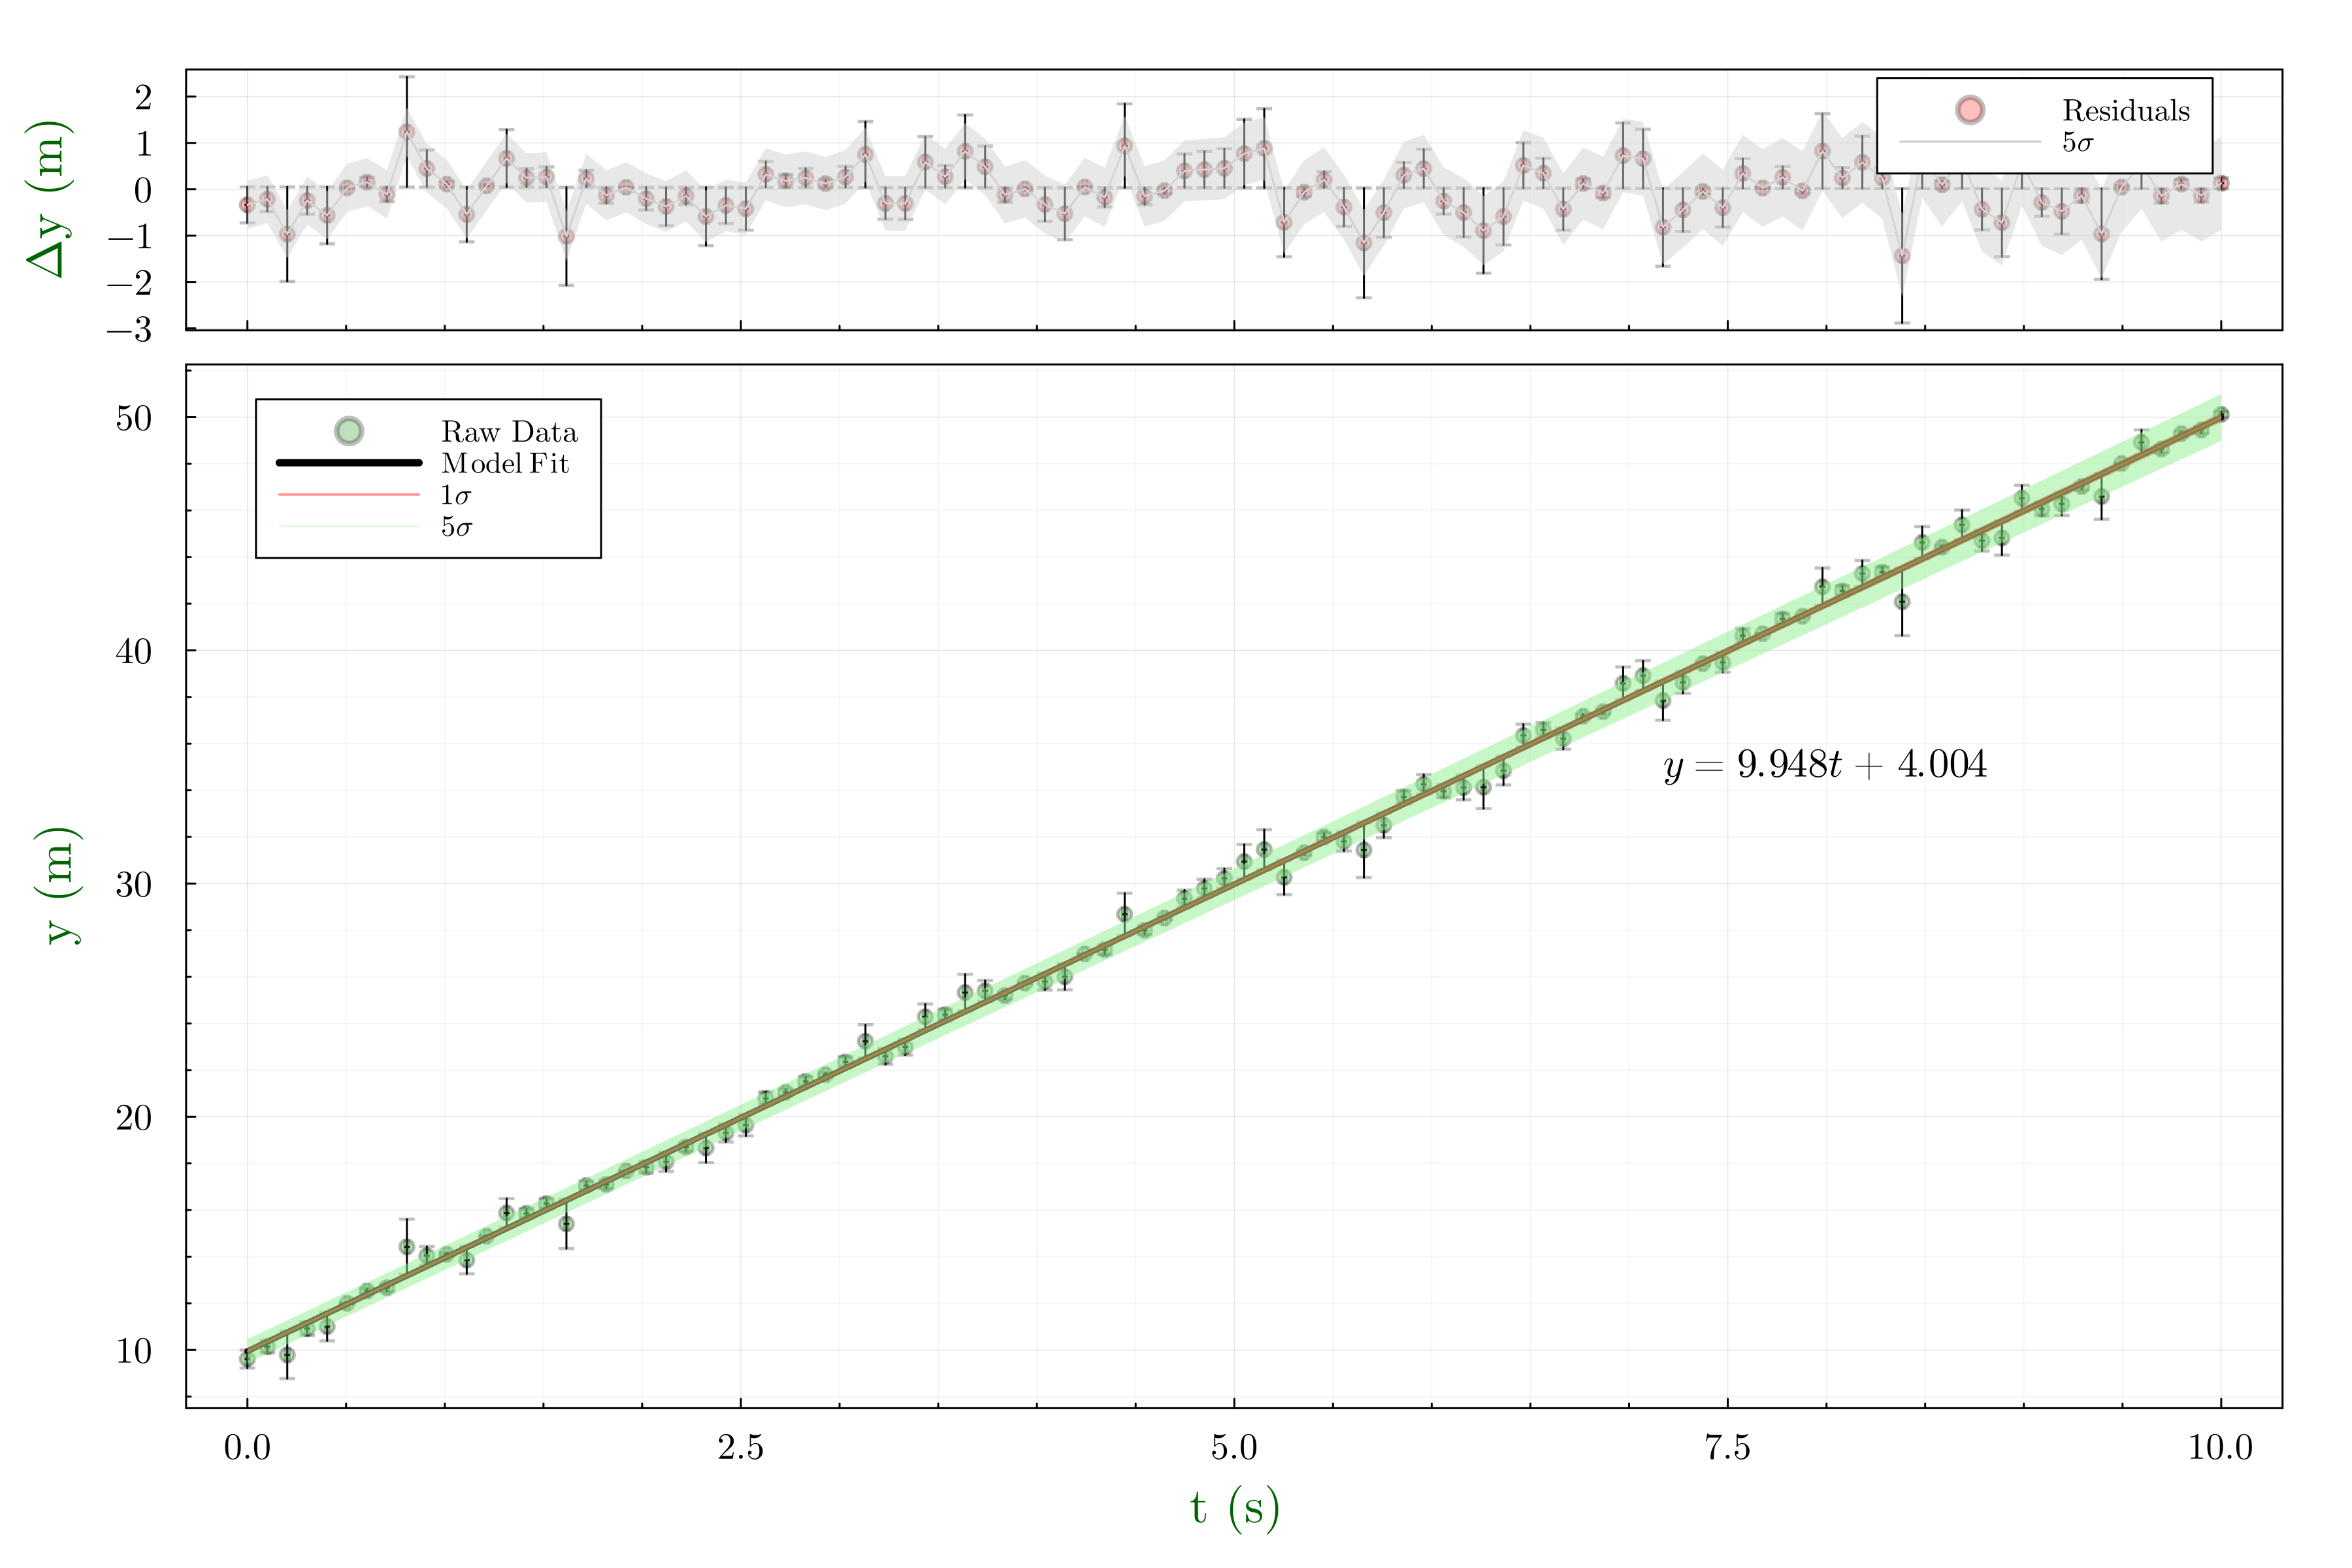

In [23]:
p, σₚ = bootstrap_fit(linear, tdata, δt, 1.0, ydata, δy,1, p0, 2000)
println("Bootstrapped fit values:")
println("p = ", round.(p; digits=4))
println("σₚ = ", round.(σₚ; digits=4))

Δy_boot = uncertainty(linear, tdata,δt, p, σₚ, 1e-6);


plot1 = scatter(tdata, ydata, color=:green, label="Raw Data", 
               xlabel = "t (s)", ylabel = "y (m)",
               xerr=δt, yerr=δy, marker=:circle, markersize=4, markeralpha=0.25,
                top_margin=-15mm, legend = :topleft)

plot!(tdata,  linear(tdata,p), label=L"$\mathrm{Model\;Fit}$", color=:black, linewidth=3)  
plot!(tdata,  linear(tdata,p), ribbon=1*Δy_boot, label=L"1\sigma",color=:red, alpha=0.4)
plot!(tdata,  linear(tdata,p), ribbon=5*Δy_boot, label=L"5\sigma", color=:lightgreen, alpha=0.2)
annotate!(
  8,
  35,
  latexstring(
    "y = $(round(p[1], digits=3))t + $(round(p[2], digits=3))"
  )
)

plot2 = scatter(tdata, ydata .- linear(tdata,p), color=:red, label="Residuals", 
         xlabel =" ", ylabel = "Δy (m)",
        xerr=δt,yerr=δy,  marker=:circle, markersize=4, markeralpha=0.25,
        xformatter=_->"", yminorgrid=false)
plot!(tdata, ydata .- linear(tdata,p), ribbon=5*Δy_boot, color=:lightgray, label=L"5\sigma")

plot(plot2, plot1, layout=grid(2, 1, heights=[0.2 ,0.8], link=:x, margin=10mm))

In [99]:
savefig("linear_fit.png")

"/Users/pauln/Dropbox/DocumentsF/Github/DataFit.jl/docs/linear_fit.png"